In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

<h1  style="color:white; background-color:blue; padding:50px; border-radius: 10px;">    
Préambule (fonctions utiles )
</h1>

On définit nos fonctions d'erreurs

In [2]:
def kaggle_error_vrai(Ypred,Yvrai):
    Ypred= pd.DataFrame(Ypred)
    Yvrai= pd.DataFrame(Yvrai)
    n = Yvrai.shape[0]
    m=0
    #print(n)
    res= 0
    for i in range(n):
        if Yvrai.iloc[i,0] != 0: # Pcq pour la pred finale, on fixera à la main les vlaurs 0 lorsque boutique fermé
            res += ( (Yvrai.iloc[i,0] - Ypred.iloc[i,0]) / Yvrai.iloc[i,0])**2
            m += 1
    return np.sqrt((1/m)*res)

In [3]:
#ici 1/n[...] et pas 1/m[...], donc on aura un eilleur score (plus petit)
def kaggle_error_vrai_2(Ypred,Yvrai):
    Ypred= pd.DataFrame(Ypred)
    Yvrai= pd.DataFrame(Yvrai)
    n = Yvrai.shape[0]
    m=0
    #print(n)
    res= 0
    for i in range(n):
        if Yvrai.iloc[i,0] != 0: # Pcq pour la pred finale, on fixera à la main les vlaurs 0 lorsque boutique fermé
            res += ( (Yvrai.iloc[i,0] - Ypred.iloc[i,0]) / Yvrai.iloc[i,0])**2
            m += 1
    return np.sqrt((1/n)*res)

Ici, c'est notre fonction pour construire des Fold selon les ID des stores

In [4]:
def KFold_index(X,K):
    #import pandasql as ps
    
    res=[]
    nbrindices = 1115 // K
    #reste = 1115 % K
    index=[i for i in range(1,1115)]
    
    for k in range(K-1):
        tmp=X.iloc[[0]]#pr avoir la bon type d'objet/ réinitialiser
        index2 = random.sample(index, nbrindices)
        
        for i in index2:
            tmp2 = X.query(f"Store == {i}")
            tmp = pd.concat([tmp,tmp2])
            index.remove(i)
            
        #index2 = np.array(index2) - 1 # pour avoir les bons indices  #### marche pas, il faudraiut queje remove par nom 
        #index = np.delete(index, index2.tolist()).tolist() # on enleve les indices utilisées avant la prochaie itération sur k
        tmp=tmp.drop([0])# on enlve la ligne de création/réinitialisation
        res.append(tmp)
      
    
    ###### On s'occupe du dernier folde, qui contiendra plus d'indices que les autres probablement    
    tmp=X.iloc[[0]]   
    for j in index:
            tmp2 = X.query(f"Store == {i}")
            tmp = pd.concat([tmp,tmp2])
    tmp=tmp.drop([0])
    res.append(tmp)
    
    
    return res


<h1  style="color:white; background-color:blue; padding:50px; border-radius: 10px;">    
I - Gestion et traitement de la donnée
</h1>


https://github.com/NikhitaMethwani/Rossman-Sales-Prediction---Time-Series/blob/master/Rossman_Sales_Prediction.ipynb


########################Modeles en mode times series###############################
https://colab.research.google.com/github/RPI-DATA/tutorials-intro/blob/master/website/Forecasting%20the%20Rossmann%20Store%20Sales.ipynb#scrollTo=qCUy3qWVKxTj





#######################Modelèes basiques avec temps pris en compte#############################
https://serhanaya.github.io/posts/kaggle-rossmann-sales-prediction/
     
https://medium.com/analytics-vidhya/rossmann-store-sales-prediction-998161027abf #avec expression kaggle error
#il y a un meta model intéressant ici à la fin + des cores de plusieurs types de modèles

<h1  style="color:white; background-color:#808b96; border-radius: 10px; padding:15px;"> Ouverture et fusion des tables train, test avec store </h1>

In [5]:
train = pd.read_csv('train.csv', low_memory=False, parse_dates=['Date'],sep=",")# le database fourni
test = pd.read_csv('test.csv',sep=",")# le database fourni
store = pd.read_csv('store.csv',sep=",")# le database fournit
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
store.head()
#store.dtypes

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
train_store = train.merge(store, how='inner',on='Store')
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [9]:
#train_store.describe()
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [10]:
##########Onsupprime les colonnes dont on ne veut pas se servir#########
train2=train_store.drop(['Customers','Promo2SinceWeek','Promo2SinceYear'],axis=1)

######################################On fill les na######################
train2.fillna(value=train2[['CompetitionDistance']].mean(),inplace=True)
train2.fillna(value=train2[['CompetitionOpenSinceMonth']].mean(),inplace=True)
train2.fillna(value=train2[['CompetitionOpenSinceYear']].mean(),inplace=True)

Promo = train2['PromoInterval'].map({ float('nan'): 0, 'Jan,Apr,Jul,Oct': 1,
                                                             'Feb,May,Aug,Nov': 2, 'Mar,Jun,Sept,Dec': 3})
#Promo
train2[['Promo2']]=Promo
train2.drop(['PromoInterval'],axis=1,inplace=True)
train2.rename(columns={'Promo2':'Promo'}, inplace=True)


######On tranformes variables qualitatives en variables quantitatives########
train2['StateHoliday'] = train2['StateHoliday'].map({'0': 0, 'a': 1, 'b': 2, 'c': 3})
train2['StoreType'] = train2['StoreType'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3})
train2['Assortment'] = train2['Assortment'].map({'a': 0, 'b': 1, 'c': 2})

In [11]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Open                       1017209 non-null  int64         
 5   Promo                      1017209 non-null  int64         
 6   StateHoliday               1017209 non-null  int64         
 7   SchoolHoliday              1017209 non-null  int64         
 8   StoreType                  1017209 non-null  int64         
 9   Assortment                 1017209 non-null  int64         
 10  CompetitionDistance        1017209 non-null  float64       
 11  CompetitionOpenSinceMonth  1017209 no

In [12]:
train2.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo
0,1,5,2015-07-31,5263,1,1,0,1,2,0,1270.0,9.0,2008.0,0
1,1,4,2015-07-30,5020,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2,1,3,2015-07-29,4782,1,1,0,1,2,0,1270.0,9.0,2008.0,0
3,1,2,2015-07-28,5011,1,1,0,1,2,0,1270.0,9.0,2008.0,0
4,1,1,2015-07-27,6102,1,1,0,1,2,0,1270.0,9.0,2008.0,0


from sklearn.preprocessing import StandardScaler

tmp_store=train2[['Store']]
std_scaler = StandardScaler()
train2_scaled = std_scaler.fit_transform(train2.drop(['Store'],axis=1).to_numpy())
#train2_scaled = np.hstack((tmp_store.to, train2_scaled))

train2_scaled = pd.DataFrame(train2_scaled, columns=['DayOfWeek','Sales','Open','Promo','StateHoliday','SchoolHoliday',
                                                     'StoreType','Assortment','CompetitionDistance'
,'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo'])

tmp_store.reset_index(inplace=True, drop=True)
train2_scaled = pd.concat([tmp_store, train2_scaled], axis=1)#, join_axes=[train2[['Store']].index])
train2_scaled.head()

In [14]:

K10fold = KFold_index(train2,10)

type(K10fold)
for i in range(10):
    #print(type(K10fold[i]))
    print(K10fold[i].shape)
    K10fold[i].shape
    K10fold[i].set_index('Date', inplace=True)
    
K10fold[0].head()

(101618, 14)
(100882, 14)
(101802, 14)
(100881, 14)
(101801, 14)
(100330, 14)
(102170, 14)
(100882, 14)
(101802, 14)
(108330, 14)


,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo
Date,,,,,,,,,,,,,
2015-07-31,834,5,8150,1,1,0,1,0,0,3470.0,3.0,2012.0,0
2015-07-30,834,4,6399,1,1,0,1,0,0,3470.0,3.0,2012.0,0
2015-07-29,834,3,6461,1,1,0,1,0,0,3470.0,3.0,2012.0,0
2015-07-28,834,2,6252,1,1,0,1,0,0,3470.0,3.0,2012.0,0
2015-07-27,834,1,7743,1,1,0,1,0,0,3470.0,3.0,2012.0,0


K10fold_scaled = KFold_index(train2_scaled,10)

type(K10fold_scaled)
for i in range(10):
    #print(type(K10fold[i]))
    print(K10fold_scaled[i].shape)


In [19]:
train2.set_index('Date', inplace=True)
train2.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2015-07-30,1,4,5020,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2015-07-29,1,3,4782,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2015-07-28,1,2,5011,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2015-07-27,1,1,6102,1,1,0,1,2,0,1270.0,9.0,2008.0,0


        -> train2: contient nos données d'entrainelent (merge de tarin.csv et store.csv et manaement des NaN). Son index est la date
        -> K10Fold: c'est un 10-fold de train2. L'in dex de ces 10 élmts est la date.
        


In [75]:
sales_a = train2[train2.Store == 2][['Sales']].sort_index(ascending = True)# store type a
sales_b = train2[train2.Store == 85][['Sales']].sort_index(ascending = True) # solve the reverse order ###store type b
sales_c = train2[train2.Store == 1][['Sales']]# store type c
sales_d = train2[train2.Store == 13][['Sales']]# store type d

<h1  style="color:white; background-color:blue; padding:50px; border-radius: 10px;">    
II - Construction de modèles
</h1>

https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/


https://moncoachdata.com/blog/modele-arima-avec-python/

https://fr.acervolima.com/python-modele-arima-pour-la-prevision-de-series-chronologiques/

In [49]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

<h1  style="color:white; background-color:#808b96; border-radius: 10px; padding:15px;"> Verification de l'hypothèse de stationnarité </h1>

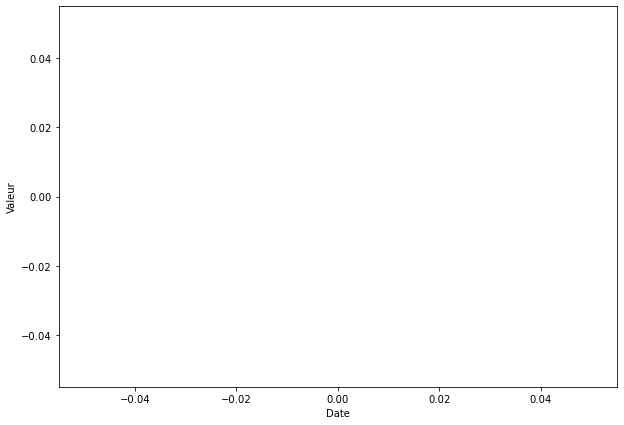

In [35]:
a=random.randint(0,9)
plt.figure(figsize=(10, 7))
plt.xlabel('Date')
plt.ylabel('Valeur')
#plt.plot(K10fold[a][['Sales']][K10fold[a].index>'2015-07-28'].values)
#plt.plot(K10fold[a][['Sales']][K10fold[a][['Store']]=='1'].values)
plt.plot(train2[['Sales']][ train2[['Store']]=='1' ].values)
plt.show()

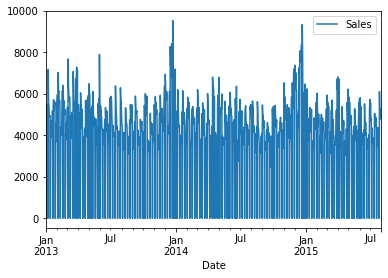

In [126]:
train2[ train2['Store'] ==1 ][['Sales']].plot()
plt.show()

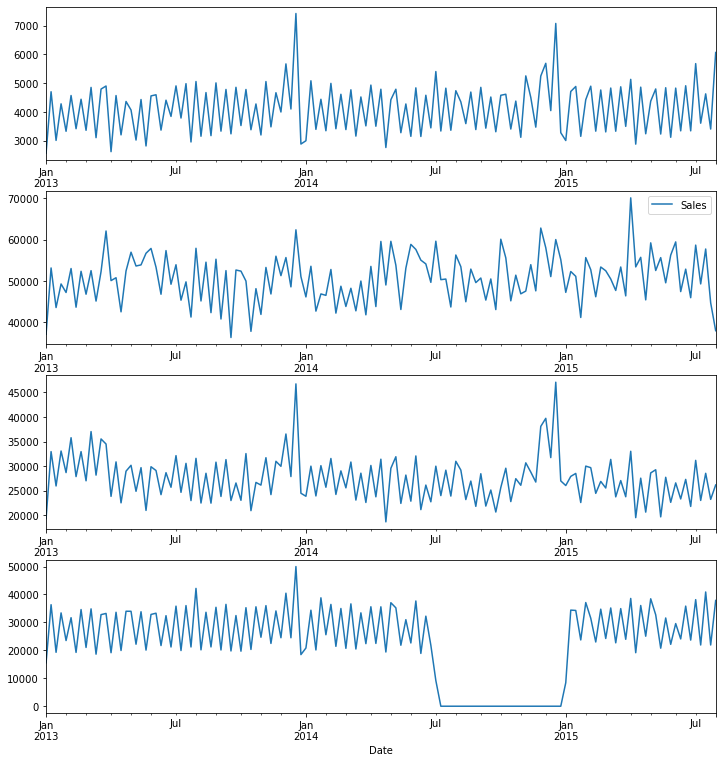

In [62]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').mean().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)
plt.show()

<h1  style="color:white; background-color:#808b96; border-radius: 10px; padding:15px;"> Le modèle AR </h1>

In [118]:
from statsmodels.tsa.ar_model import AutoReg




X_train=sales_a['2015-03-01':'2015-06-30'].asfreq('d')

# train autoregression
model = AutoReg(X_train, lags=7,old_names=True)
model_fit = model.fit()#.fit(disp=0) pour cacher (ou -1)

#print('Coefficients: %s' % model_fit.params)
# make predictions
X_pred = model_fit.predict(start=pd.to_datetime('2015-07-01'), end=pd.to_datetime('2015-07-31'), dynamic=False)
X_test = sales_a['2015-07-01':'2015-07-31']

In [119]:
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(X_test,X_pred))

1687.7998727506094

In [120]:
kaggle_error_vrai(X_pred,X_test)

0.28822685642448415

In [121]:
kaggle_error_vrai_2(X_pred,X_test)

0.26898959451257265

On va essayer de trouver la valeur optimale de p pour AR(p)

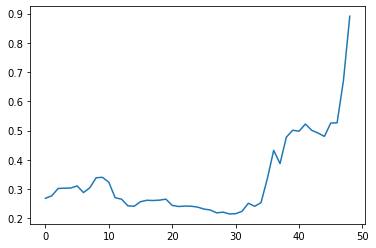

In [122]:
val_score = []
for k in range(1, 50):
    score1 = kaggle_error_vrai(AutoReg(X_train, lags=k,old_names=True).fit().predict(start=pd.to_datetime('2015-07-01'), 
                                                            end=pd.to_datetime('2015-07-31'), 
                                                            dynamic=False), X_test)
    val_score.append(score1)
plt.plot(val_score)
plt.show()

In [125]:
model = AutoReg(X_train, lags=30,old_names=True)
model_fit = model.fit()#.fit(disp=0) pour cacher (ou -1)
X_pred = model_fit.predict(start=pd.to_datetime('2015-07-01'), end=pd.to_datetime('2015-07-31'), dynamic=False)
X_test = sales_a['2015-07-01':'2015-07-31']

print('pour p=30 on a:')
print('RMSE = ',np.sqrt(metrics.mean_squared_error(X_test,X_pred)))
print('RMSPE_1 = ',kaggle_error_vrai(X_pred,X_test))
print('RMSPE_2 = ',kaggle_error_vrai_2(X_pred,X_test))

pour p=30 on a:
RMSE =  1008.3987144946727
RMSPE_1 =  0.21520627469027367
RMSPE_2 =  0.20084266013103066


C'est beacoup mieux qu'avec nos simples modèles linéaires :) !!